Data source: https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cp '/content/drive/MyDrive/Brain_MRI.zip' .
!unzip -q Brain_MRI.zip
!rm Brain_MRI.zip

replace Brain_MRI/data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
replace Brain_MRI/data_mask.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A
Y


In [3]:
%cd /content/Brain_MRI

/content/Brain_MRI


In [4]:
import pandas as pd
brain_mri_df=pd.read_csv('data_mask.csv')

In [5]:
brain_mri_df.head()
#we have image path and mask path 
#if mask=1 the we have corresponding mask also
#we use this condition to seperate MRI with mask to perform segmentation

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


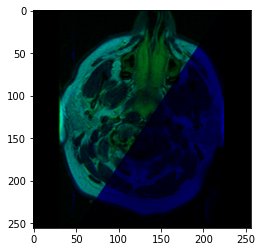

In [6]:
import matplotlib.pyplot as plt
import cv2
plt.imshow(cv2.imread(brain_mri_df.image_path[3]))


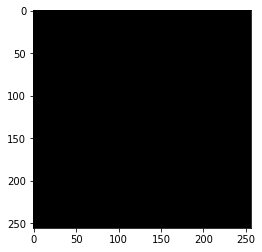

In [7]:
plt.imshow(cv2.imread(brain_mri_df.mask_path[3]))

In [8]:
brain_mask_df=brain_mri_df[brain_mri_df['mask'] ==1 ]
brain_mask_df=brain_mask_df.reset_index(drop=True)
#if we dont drop index we cant plot images randomly as index may not be valid
brain_mask_df.head()

,patient_id,image_path,mask_path,mask
0,TCGA_DU_5872_19950223,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5_...,1
1,TCGA_DU_5874_19950510,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_5.tif,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_5_...,1
2,TCGA_DU_5854_19951104,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_6.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_6_...,1
3,TCGA_DU_5854_19951104,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_6.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_6_...,1
4,TCGA_DU_5853_19950823,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6.tif,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6_...,1


In [9]:
print(brain_mask_df.image_path[0])

TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5.tif


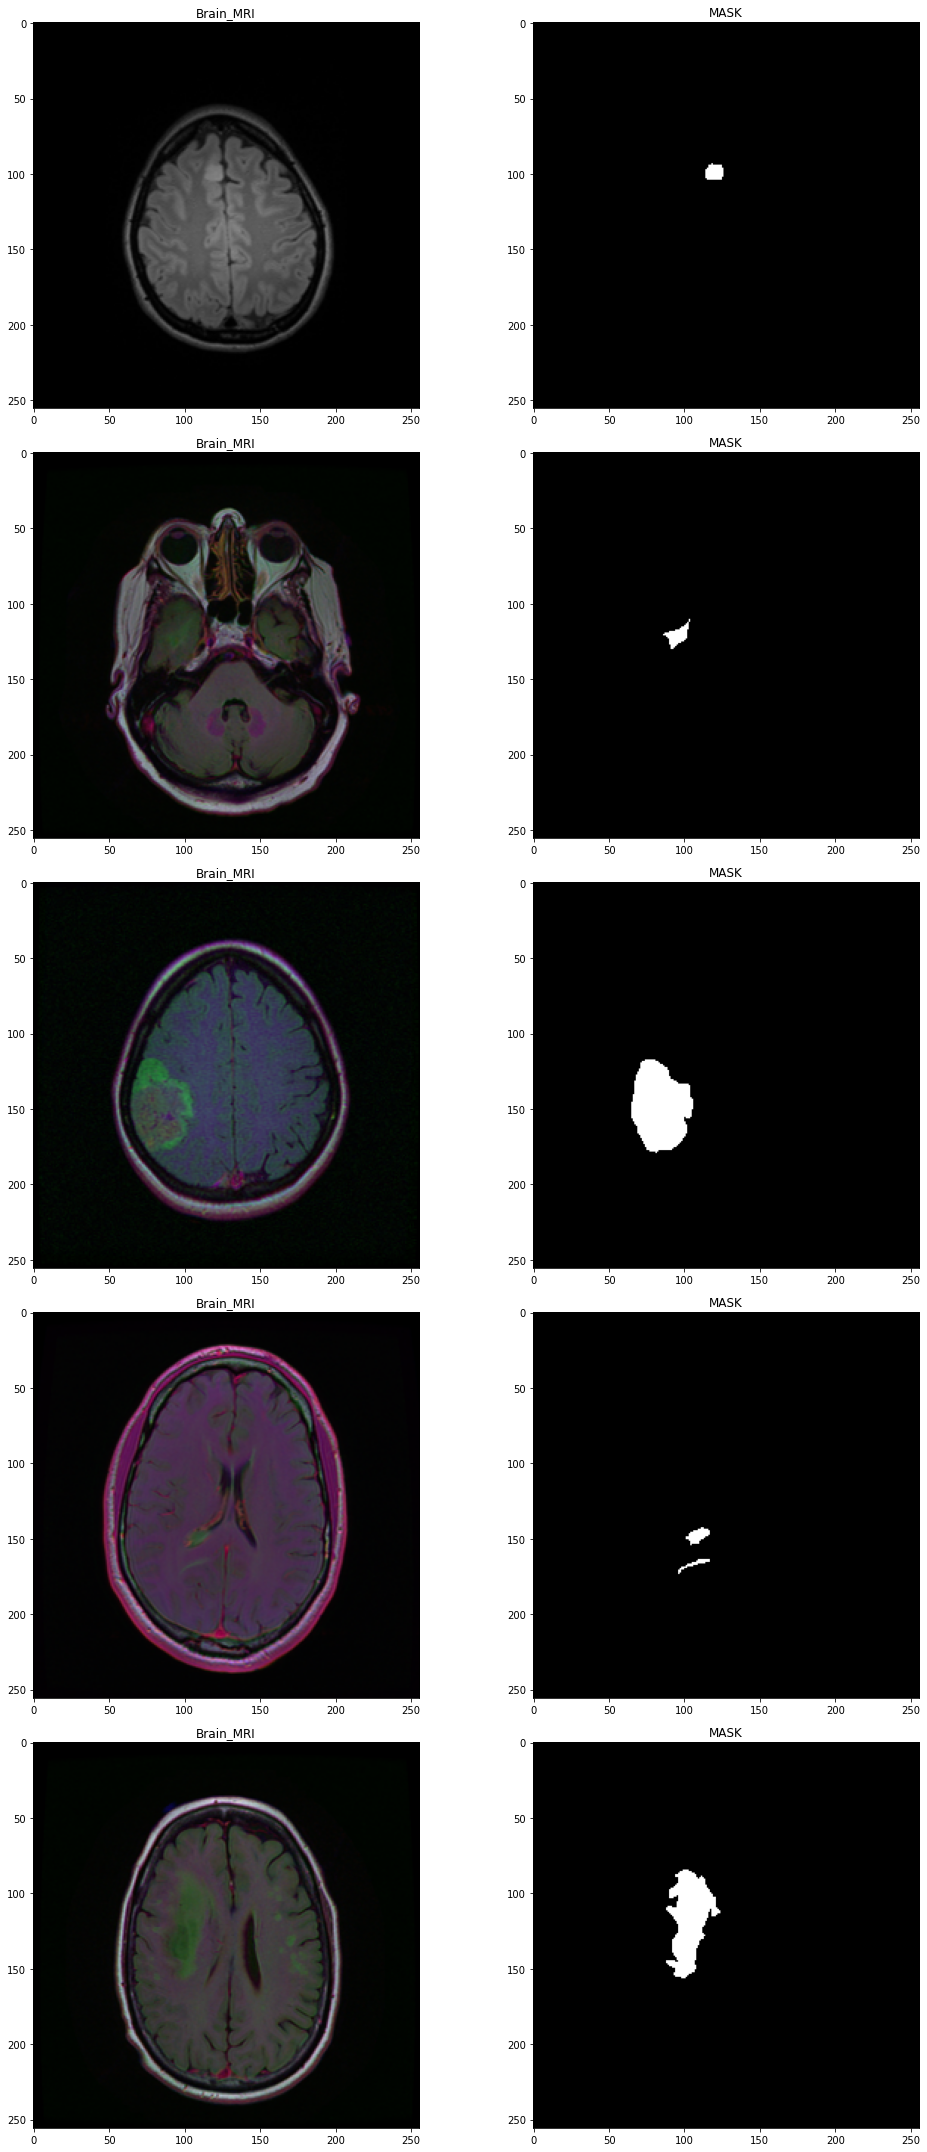

In [10]:
import random
fig, axs=plt.subplots(5,2,figsize=(15,30))
for i in range(5):
  j=random.randint(0,len(brain_mask_df))
  axs[i][0].title.set_text('Brain_MRI')
  axs[i][0].imshow(cv2.imread(brain_mask_df.image_path[j]))
  axs[i][1].title.set_text('MASK')
  axs[i][1].imshow(cv2.imread(brain_mask_df.mask_path[j]))
fig.tight_layout()

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(brain_mask_df, test_size=0.15)
train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

test_ids = list(X_test.image_path)
test_mask= list(X_test.mask_path)

In [12]:
import numpy as np
def create_array_from_paths(list1):
  list2=[]
  for i in range (len(list1)):
    img=cv2.imread(list1[i])
    list2.append(img)
  arr1=np.array(list2)
  return arr1


In [13]:
X_train=create_array_from_paths(train_ids)
X_train=X_train/255.
Y_train=create_array_from_paths(train_mask)
Y_train=Y_train/255.
X_test=create_array_from_paths(test_ids)
X_test=X_test/255.
Y_test=create_array_from_paths(test_mask)
Y_test=Y_test/255.
print(X_train.shape)
print(Y_train.shape)

(1167, 256, 256, 3)
(1167, 256, 256, 3)


In [14]:
import numpy as np
import seaborn as sns
from skimage import io
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [15]:
def resblock(X, f):
  

  # make a copy of input
  X_copy = X

  # main path
  
  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  
  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [16]:
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [17]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(3, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )

In [18]:
model_seg.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [28]:
from utilities import focal_tversky, tversky_loss, tversky
adam = tf.keras.optimizers.Adam(lr = 0.01, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [29]:

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)

In [30]:
history = model_seg.fit(X_train, Y_train, epochs = 100, validation_split = 0.05, callbacks = [checkpointer])

Epoch 1/100
35/35 [==============================] - ETA: 0s - loss: 0.0857 - tversky: 0.9622
Epoch 00001: val_loss improved from inf to 0.20432, saving model to ResUNet-weights.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


35/35 [==============================] - 31s 766ms/step - loss: 0.0857 - tversky: 0.9622 - val_loss: 0.2043 - val_tversky: 0.8765
Epoch 2/100
35/35 [==============================] - ETA: 0s - loss: 0.0846 - tversky: 0.9628
Epoch 00002: val_loss did not improve from 0.20432
35/35 [==============================] - 26s 732ms/step - loss: 0.0846 - tversky: 0.9628 - val_loss: 0.2060 - val_tversky: 0.8755
Epoch 3/100
35/35 [==============================] - ETA: 0s - loss: 0.0832 - tversky: 0.9636
Epoch 00003: val_loss did not improve from 0.20432
35/35 [==============================] - 26s 733ms/step - loss: 0.0832 - tversky: 0.9636 - val_loss: 0.2069 - val_tversky: 0.8747
Epoch 4/100
35/35 [==============================] - ETA: 0s - loss: 0.0830 - tversky: 0.9638
Epoch 00004: val_loss improved from 0.20432 to 0.20185, saving model to ResUNet-weights.hdf5
35/35 [==============================] - 26s 747ms/step - loss: 0.0830 - tversky: 0.9638 - val_loss: 0.2019 - val_tversky: 0.8785
Epo

KeyboardInterrupt: ignored

In [31]:
model_seg.load_weights('ResUNet-weights.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [32]:
pred=model_seg.predict(X_test)
pred[1].shape

(256, 256, 3)

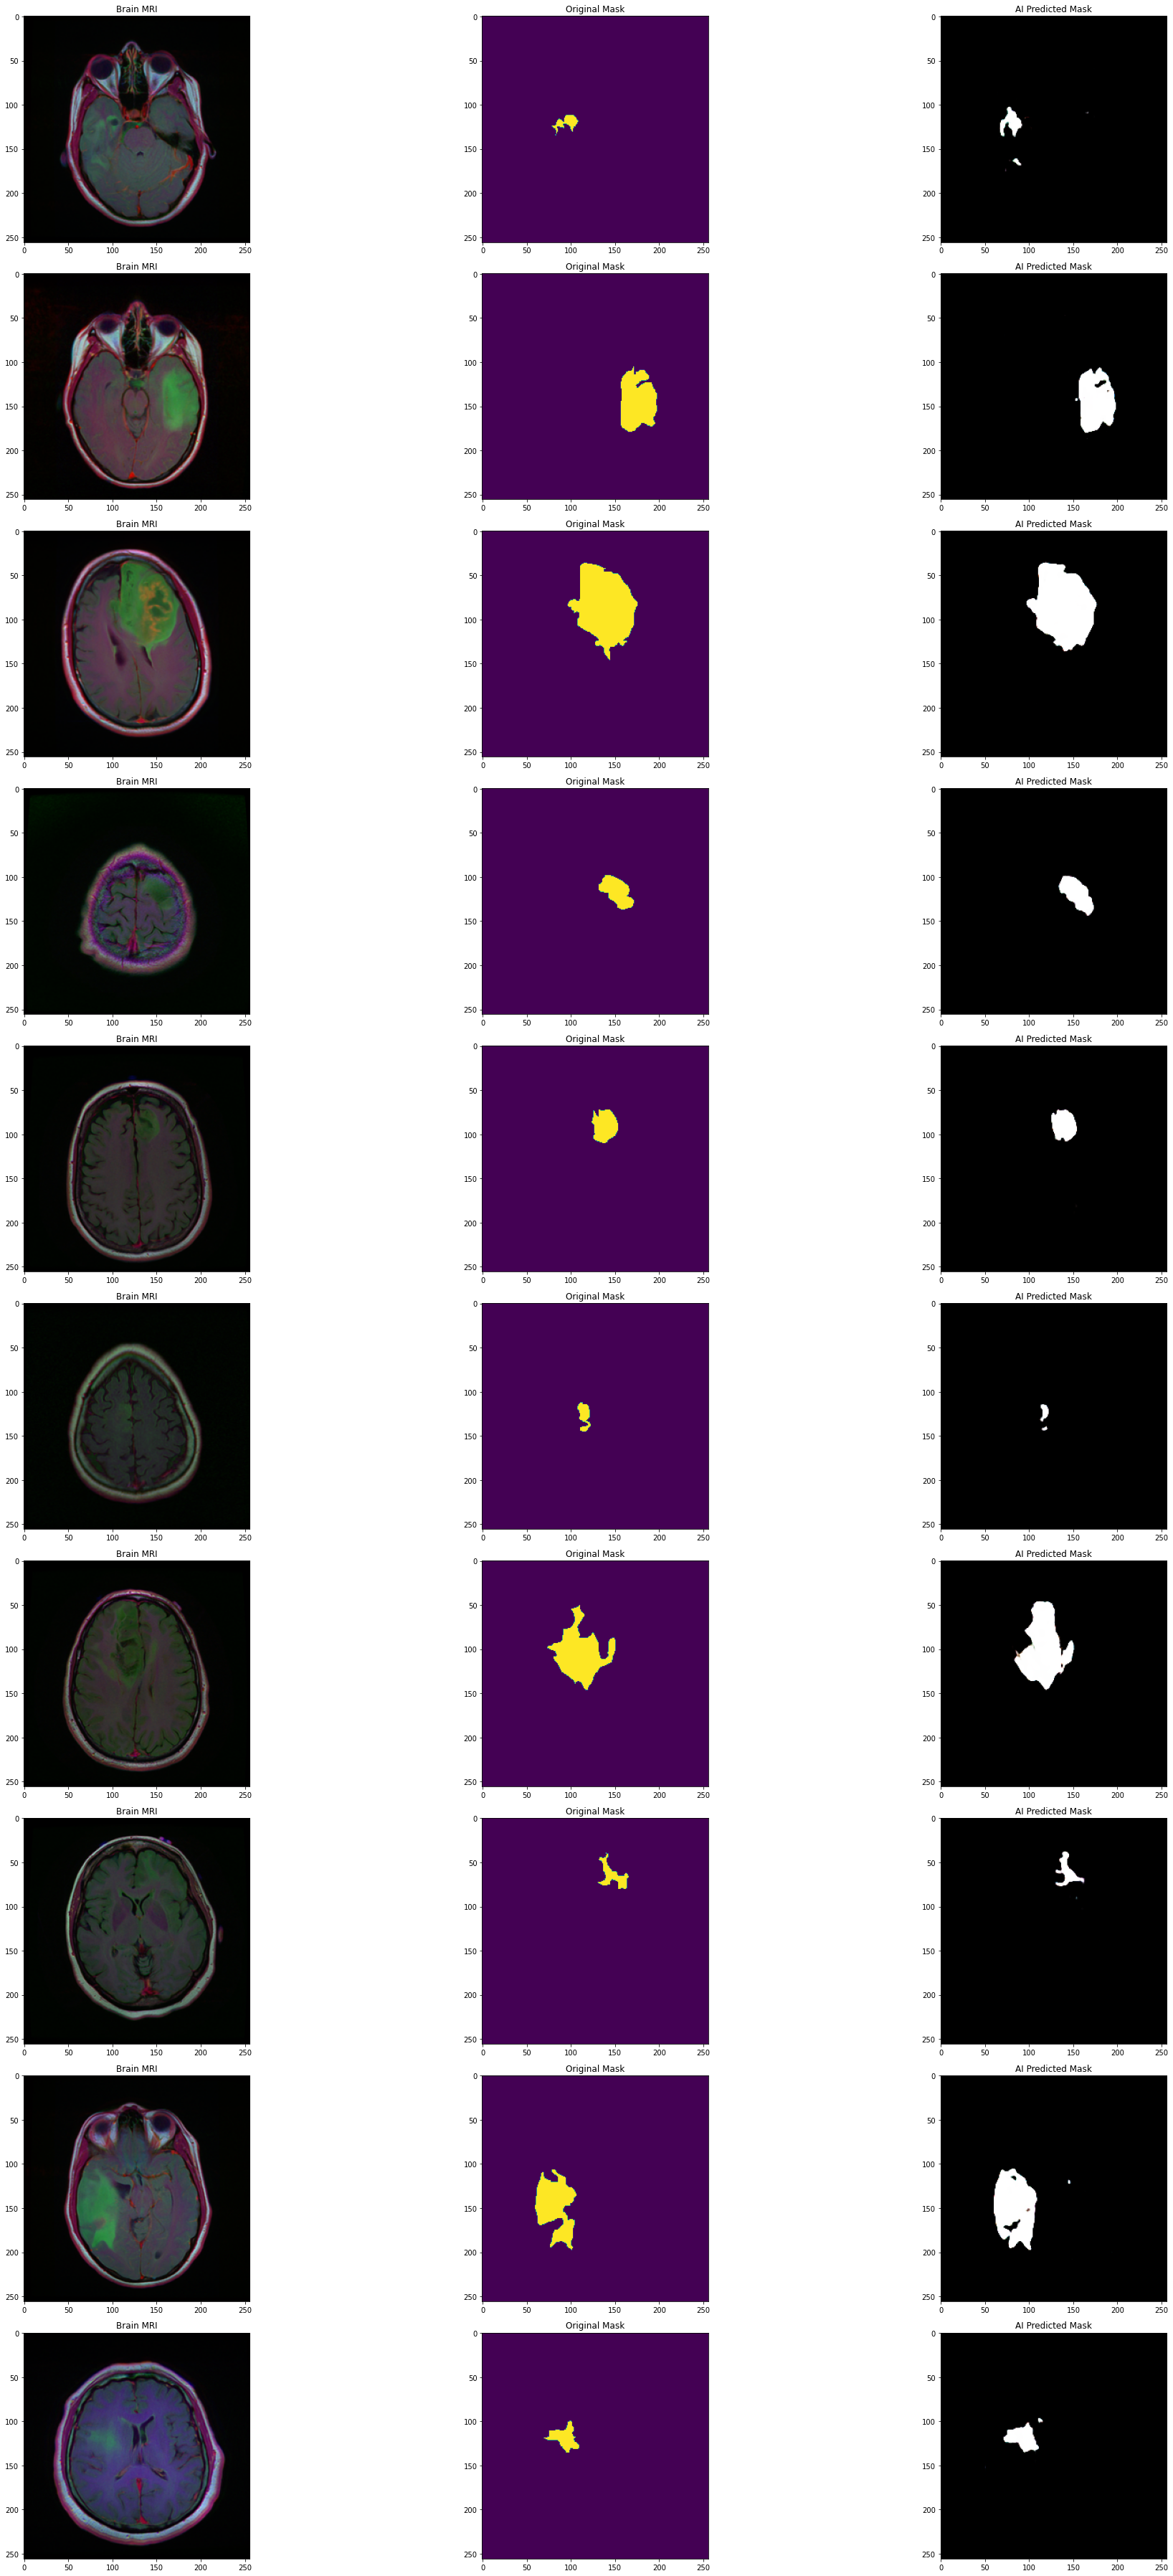

In [33]:
count = 0 
fig, axs = plt.subplots(10, 3, figsize=(30, 50))
for i in range(10):
    # read the images and convert them to RGB format
    img = io.imread(test_ids[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image 
    mask = io.imread(test_mask[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image 
    predicted_mask = pred[i]
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    count+=1
    

fig.tight_layout()